In [2]:
# Importer les bibliothèques nécessaires
import os
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras.metrics import Recall, AUC

# Configuration initiale
print("="*72)

%reload_ext watermark
%watermark -a "touati Saber" -u -d -m

print("="*72)
print("Imported Packages and Their Versions:")
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("="*72)

%watermark -iv
print("="*72)

# Désactiver les optimisations OneDNN (si nécessaire)
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'



Author: touati Saber

Last updated: 2025-02-03

Compiler    : GCC 13.3.0
OS          : Linux
Release     : 5.15.167.4-microsoft-standard-WSL2
Machine     : x86_64
Processor   : x86_64
CPU cores   : 12
Architecture: 64bit

Imported Packages and Their Versions:
Num GPUs Available:  1
seaborn   : 0.13.2
pandas    : 2.2.3
numpy     : 2.0.2
keras     : 3.8.0
tensorflow: 2.18.0
sklearn   : 1.6.1
imblearn  : 0.13.0
matplotlib: 3.10.0



In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("mlg-ulb/creditcardfraud")

print("Path to dataset files:", path)

Path to dataset files: /home/unixsaber/.cache/kagglehub/datasets/mlg-ulb/creditcardfraud/versions/3


In [6]:

# Définir le chemin du dataset téléchargé
dataset_path = "/home/unixsaber/.cache/kagglehub/datasets/mlg-ulb/creditcardfraud/versions/3/creditcard.csv"
csv_path = os.path.join(dataset_path, "creditcard.csv")

# Charger le dataset dans un DataFrame
df = pd.read_csv(dataset_path)

# Afficher les premières lignes du dataset
print("Premières lignes du dataset :")
print(df.head())

# Fonction pour analyser les données manquantes
def analyze_missing_data(data):
    """Analyse les données manquantes dans le DataFrame."""
    print("Analyse des données manquantes :")
    print(data.isnull().sum())

# Appeler la fonction pour analyser les données manquantes
analyze_missing_data(df)

def load_and_preprocess_data(filepath):
    """Charge, normalise et équilibre les données avec SMOTE."""
    # df = pd.read_csv(filepath)
    
    X = df.drop(columns=['Class'])
    y = df['Class']

    # Normalisation
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Équilibrage des classes avec SMOTE
    smote = SMOTE(sampling_strategy=0.5, random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

    return train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Exécuter cette cellule pour charger les données
filepath = "creditcard.csv"  # Modifier avec le chemin réel
X_train, X_test, y_train, y_test = load_and_preprocess_data(filepath)

# Vérification des classes
print("Distribution après SMOTE:")
print(pd.Series(y_train).value_counts())

# Afficher les informations du DataFrame
print("\nInformations du dataset :")
df.info()

Premières lignes du dataset :
   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

  

In [7]:
# Check the data description
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Time,284807.0,9.481386e+04,47488.145955,0.000000,54201.500000,84692.000000,139320.500000,172792.000000
V1,284807.0,1.168375e-15,1.958696,-56.407510,-0.920373,0.018109,1.315642,2.454930
V2,284807.0,3.416908e-16,1.651309,-72.715728,-0.598550,0.065486,0.803724,22.057729
V3,284807.0,-1.379537e-15,1.516255,-48.325589,-0.890365,0.179846,1.027196,9.382558
V4,284807.0,2.074095e-15,1.415869,-5.683171,-0.848640,-0.019847,0.743341,16.875344
V5,284807.0,9.604066e-16,1.380247,-113.743307,-0.691597,-0.054336,0.611926,34.801666
V6,284807.0,1.487313e-15,1.332271,-26.160506,-0.768296,-0.274187,0.398565,73.301626
V7,284807.0,-5.556467e-16,1.237094,-43.557242,-0.554076,0.040103,0.570436,120.589494
V8,284807.0,1.213481e-16,1.194353,-73.216718,-0.208630,0.022358,0.327346,20.007208
V9,284807.0,-2.406331e-15,1.098632,-13.434066,-0.643098,-0.051429,0.597139,15.594995


In [8]:
def create_model(input_shape):
    """Crée un modèle robuste pour la détection de fraude."""
    model = Sequential([
        Dense(128, activation='relu', kernel_regularizer=l2(0.01), input_shape=input_shape),
        BatchNormalization(),
        Dropout(0.4),
        Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy', Recall(name='recall'), AUC(name='auc')])
    
    
    return model

    
# Créer le modèle
model = create_model(input_shape=(X_train.shape[1],))

# Afficher le résumé du modèle
model.summary()


/home/unixsaber/tensorflow_env/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1738537697.161112   21974 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1768 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2050, pci bus id: 0000:01:00.0, compute capability: 8.6


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         3,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,057 (51.00 KB)

 Trainable params: 12,673 (49.50 KB)

 Non-trainable params: 384 (1.50 KB)

In [9]:
def train_model(model, X_train, y_train):
    """Entraîne le modèle avec callbacks et pondération des classes."""
    early_stopping = EarlyStopping(
        monitor='val_loss', patience=5, min_delta=0.0001, restore_best_weights=True
    )
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=1e-5)

    history = model.fit(
        X_train, y_train,
        epochs=50, batch_size=32, validation_split=0.2,
        class_weight={0: 1, 1: 5},  # Favoriser la détection de fraudes
        callbacks=[early_stopping, reduce_lr],
        verbose=1
    )

    return history

# Entraîner le modèle
history = train_model(model, X_train, y_train)

Epoch 1/50


I0000 00:00:1738537711.749601   22099 service.cc:148] XLA service 0x7f0a64005890 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1738537711.749713   22099 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 2050, Compute Capability 8.6
2025-02-03 00:08:31.786361: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1738537711.940015   22099 cuda_dnn.cc:529] Loaded cuDNN version 90300


  11/8530 ━━━━━━━━━━━━━━━━━━━━ 1:27 10ms/step - accuracy: 0.7940 - auc: 0.8790 - loss: 2.2796 - recall: 0.8676 

I0000 00:00:1738537713.121208   22099 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


8530/8530 ━━━━━━━━━━━━━━━━━━━━ 82s 9ms/step - accuracy: 0.9469 - auc: 0.9908 - loss: 0.5885 - recall: 0.9728 - val_accuracy: 0.9879 - val_auc: 0.9990 - val_loss: 0.1365 - val_recall: 0.9947 - learning_rate: 0.0010
Epoch 2/50
8530/8530 ━━━━━━━━━━━━━━━━━━━━ 78s 9ms/step - accuracy: 0.9737 - auc: 0.9965 - loss: 0.2180 - recall: 0.9897 - val_accuracy: 0.9890 - val_auc: 0.9994 - val_loss: 0.1275 - val_recall: 0.9985 - learning_rate: 0.0010
Epoch 3/50
8530/8530 ━━━━━━━━━━━━━━━━━━━━ 82s 10ms/step - accuracy: 0.9769 - auc: 0.9972 - loss: 0.1946 - recall: 0.9914 - val_accuracy: 0.9911 - val_auc: 0.9991 - val_loss: 0.1195 - val_recall: 0.9972 - learning_rate: 0.0010
Epoch 4/50
8530/8530 ━━━━━━━━━━━━━━━━━━━━ 81s 9ms/step - accuracy: 0.9800 - auc: 0.9978 - loss: 0.1741 - recall: 0.9927 - val_accuracy: 0.9939 - val_auc: 0.9996 - val_loss: 0.0984 - val_recall: 0.9985 - learning_rate: 0.0010
Epoch 5/50
8530/8530 ━━━━━━━━━━━━━━━━━━━━ 80s 9ms/step - accuracy: 0.9804 - auc: 0.9978 - loss: 0.1701 - recal

In [10]:
def evaluate_model(model, X_test, y_test, threshold=0.3):
    """Évalue le modèle avec un seuil ajusté."""
    y_pred_prob = model.predict(X_test)
    y_pred = (y_pred_prob > threshold).astype(int)

    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))

    print(f"AUC-ROC Score: {roc_auc_score(y_test, y_pred_prob):.4f}")

    return y_pred, y_pred_prob

# Évaluation
y_pred, y_pred_prob = evaluate_model(model, X_test, y_test)

2666/2666 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56777
           1       1.00      1.00      1.00     28518

    accuracy                           1.00     85295
   macro avg       1.00      1.00      1.00     85295
weighted avg       1.00      1.00      1.00     85295

Confusion Matrix:
[[56680    97]
 [    0 28518]]
AUC-ROC Score: 0.9999


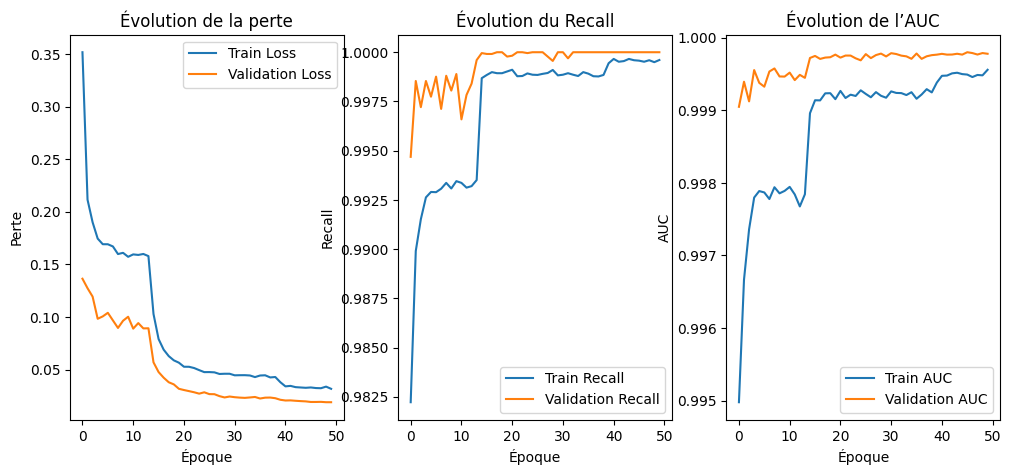

In [11]:
def plot_metrics(history):
    """Affiche les métriques d'entraînement."""
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 3, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Époque')
    plt.ylabel('Perte')
    plt.legend()
    plt.title('Évolution de la perte')

    plt.subplot(1, 3, 2)
    plt.plot(history.history['recall'], label='Train Recall')
    plt.plot(history.history['val_recall'], label='Validation Recall')
    plt.xlabel('Époque')
    plt.ylabel('Recall')
    plt.legend()
    plt.title('Évolution du Recall')

    plt.subplot(1, 3, 3)
    plt.plot(history.history['auc'], label='Train AUC')
    plt.plot(history.history['val_auc'], label='Validation AUC')
    plt.xlabel('Époque')
    plt.ylabel('AUC')
    plt.legend()
    plt.title('Évolution de l’AUC')

    plt.show()

# Affichage des métriques
plot_metrics(history)